In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import ticker, cm
import matplotlib.colors as colors
import matplotlib.animation as animation
from IPython.display import HTML, display

In [2]:
def himmelblau(x):
    return (x[0]**2 + x[1] - 11)**2 + (x[0] + x[1]**2 - 7)**2

In [3]:
def plot_2d(X, Y):
    fig = plt.figure(figsize=(8, 6))
    cs = plt.contour(X[0], X[1], Y, levels=100, cmap='Spectral',
                 norm=colors.Normalize(vmin=Y.min(), vmax=Y.max()), alpha=0.4)
    fig.colorbar(cs)
    plt.show()
    
def plot_3d(X, Y):
    fig = plt.figure(figsize=(13, 10))
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(X[0], X[1], Y, cmap=cm.nipy_spectral,
                norm=colors.Normalize(vmin=Y.min(), vmax=Y.max()), alpha=0.4)
    fig.colorbar(surf)
    plt.show()

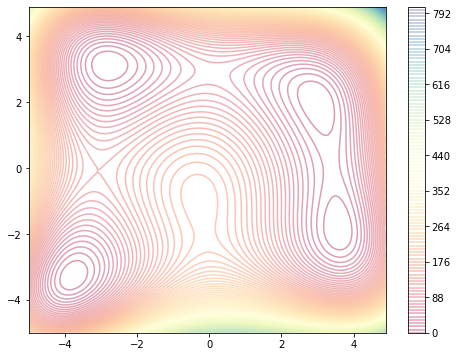

In [4]:
X_min = -5
X_max = 5
X = np.meshgrid(np.arange(X_min, X_max, 0.1), np.arange(X_min, X_max, 0.1))
Y = himmelblau(X)

plot_2d(X, Y)

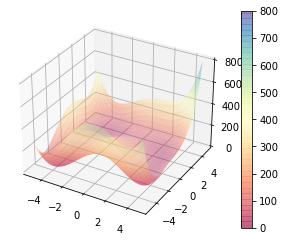

In [9]:
plot_3d(X, Y)

In [61]:
def de_rand(fobj, bounds, mut=0.8, crossp=0.7, popsize=20, its=100):
    dimensions = len(bounds) #bounds as (min,max) or [(min1,max1),(min2,max2)] or...
    pop = np.random.rand(popsize, dimensions) #Random initiation, coordinates between 0 and 1
    min_b, max_b = np.asarray(bounds).T #Convert to an array
    diff = np.fabs(min_b - max_b) #Absolute value
    pop_denorm = min_b + pop * diff
    fitness = np.asarray([fobj(ind) for ind in pop_denorm]) #Applying fobj to all the pop
    best_idx = np.argmin(fitness)
    best = pop_denorm[best_idx] #Pop's element with the smallest value of fobj
    for i in range(its):
        for j in range(popsize):
            idxs = [idx for idx in range(popsize) if idx != j]
            a, b, c = pop[np.random.choice(idxs, 3, replace = False)] #Selects 3 vectors from pop\{pop[j]} randomly, without duplication
            mutant = np.clip(a + mut * (b - c), 0, 1) #If (a+mut*(b-c))<0, return 0, and if it's >1, return 1 -> normalization
            cross_points = np.random.rand(dimensions) < crossp #In the dimensions where the result is TRUE -> recombination
            if not np.any(cross_points): #If all the tests are FALSE, force one to be TRUE
                cross_points[np.random.randint(0, dimensions)] = True
            trial = np.where(cross_points, mutant, pop[j]) #Recombination : Crossover between mutant and pop[j]
            trial_denorm = min_b + trial * diff
            f = fobj(trial_denorm)
            if f < fitness[j]: #Test to see if mutant will be kept or not
                fitness[j] = f
                pop[j] = trial
                if f < fitness[best_idx]:
                    best_idx = j
                    best = trial_denorm
        yield  min_b + pop * diff

In [65]:
def de_best(fobj, bounds, mut=0.8, crossp=0.7, popsize=20, its=100):
    dimensions = len(bounds) #bounds as (min,max) or [(min1,max1),(min2,max2)] or...
    pop = np.random.rand(popsize, dimensions) #Random initiation, coordinates between 0 and 1
    min_b, max_b = np.asarray(bounds).T #Convert to an array
    diff = np.fabs(min_b - max_b) #Absolute value
    pop_denorm = min_b + pop * diff
    fitness = np.asarray([fobj(ind) for ind in pop_denorm]) #Applying fobj to all the pop
    best_idx = np.argmin(fitness)
    best = pop_denorm[best_idx] #Pop's element with the smallest value of fobj
    best_norm = pop[best_idx]
    for i in range(its):
        for j in range(popsize):
            idxs = [idx for idx in range(popsize) if idx != j]
            b, c = pop[np.random.choice(idxs, 2, replace = False)] #Selects 2 vectors from pop\{pop[j]} randomly, without duplication
            mutant = np.clip(best_norm + mut * (b - c), 0, 1) #If (best+mut*(b-c))<0, return 0, and if it's >1, return 1 -> normalization
            cross_points = np.random.rand(dimensions) < crossp #In the dimensions where the result is TRUE -> recombination
            if not np.any(cross_points): #If all the tests are FALSE, force one to be TRUE
                cross_points[np.random.randint(0, dimensions)] = True
            trial = np.where(cross_points, mutant, pop[j]) #Recombination : Crossover between mutant and pop[j]
            trial_denorm = min_b + trial * diff
            f = fobj(trial_denorm)
            if f < fitness[j]: #Test to see if mutant will be kept or not
                fitness[j] = f
                pop[j] = trial
                if f < fitness[best_idx]:
                    best_idx = j
                    best = trial_denorm
                    best_norm = trial
        yield min_b + pop * diff

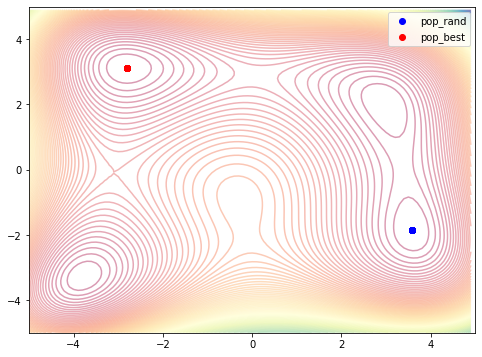

In [21]:
fig = plt.figure(figsize=(8,6))
ax = plt.subplot()
norm = colors.Normalize(vmin=Y.min(), vmax=Y.max())
its = 100

result_rand = list(de_rand(himmelblau, [(-5, 5)] * 2, its=its))
result_best = list(de_best(himmelblau, [(-5, 5)] * 2, its=its))

def animate(i):
    ax.clear()
    ax.contour(X[0], X[1], Y, levels=100, cmap='Spectral', alpha=0.4, norm=norm)
    pop_rand = result_rand[i]
    ax.scatter(pop_rand[:,0], pop_rand[:,1], label="pop_rand", c='b')
    pop_best = result_best[i]
    ax.scatter(pop_best[:,0], pop_best[:,1], label="pop_best", c='r')
    ax.set_ylim(-5, 5)
    ax.set_xlim(-5, 5)
    ax.legend()
    ax.plot()

anim = animation.FuncAnimation(fig, animate, frames=its, interval=250)
HTML(anim.to_html5_video())

In [69]:
#Comparison with the Genetic Algorithm seen in class

from pymoo.operators.crossover import edge_recombination_crossover as erc

def tournament_selection(population, fitness, t_size=3):
    rng = np.random.default_rng()
    tournament = rng.choice(len(population), size=t_size)
    ind = tournament[np.argmin(fitness[tournament])]
    return population[ind], fitness[ind]

def truncation_selection(population, fitness, p):
    n_elites = int(np.floor(len(population) * p))
    elites = np.argsort(fitness)[:n_elites]
    return population[elites], fitness[elites]

def mutate(ind):
    i = int(np.random.rand()*(len(ind)-2))
    ind[i], ind[i+1] = ind[i+1], ind[i]
    return ind

def ga_step(fobj, population, p=0.2):
    fitness = np.asarray([fobj(ind) for ind in population])
    next_pop, _ = truncation_selection(population, fitness, p=p)
    while len(next_pop) < len(population):
        parent1, _ = tournament_selection(population, fitness)
        parent2, _ = tournament_selection(population, fitness)
        child = erc.erx(parent1, parent2)
        child = mutate(child)
        next_pop = np.concatenate((next_pop, [child]))
    return next_pop

def ga(fobj, n_population=20, n_gen=100):
    population = np.array([[np.random.rand()*(X_max-X_min)+X_min, np.random.rand()*(X_max-X_min)+X_min] for i in range(n_population)])
    result_ga = ["" for i in range (100)]
    for i in range(n_gen):
        population = ga_step(fobj, population)
        result_ga[i] = np.copy(population)
    return result_ga

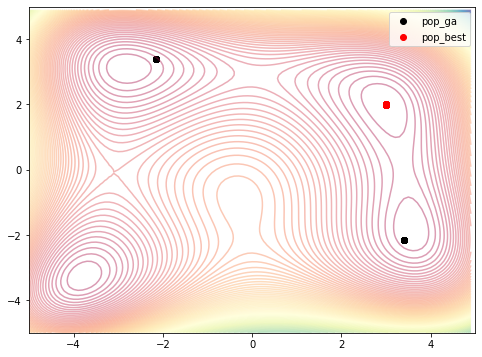

In [72]:
fig = plt.figure(figsize=(8,6))
ax = plt.subplot()
norm = colors.Normalize(vmin=Y.min(), vmax=Y.max())
its = 25

result_best = list(de_best(himmelblau, [(-5, 5)] * 2, its=its))
result_ga = ga(himmelblau, n_gen=its)

def animate(i):
    ax.clear()
    ax.contour(X[0], X[1], Y, levels=100, cmap='Spectral', alpha=0.4, norm=norm)
    pop_ga = result_ga[i]
    ax.scatter(pop_ga[:,0], pop_ga[:,1], label="pop_ga", c='k')
    pop_best = result_best[i]
    ax.scatter(pop_best[:,0], pop_best[:,1], label="pop_best", c='r')
    ax.set_ylim(-5, 5)
    ax.set_xlim(-5, 5)
    ax.legend()
    ax.plot()

anim = animation.FuncAnimation(fig, animate, frames=its, interval=250)
HTML(anim.to_html5_video())

In [67]:
#Comparison with PopSize+lambda Algorithm and the Gradient Algorithm

def onepluslambda(fobj, lmbda=10, its=100, popsize=20):
    result = ["" for i in range(its)]
    x = np.array([[np.random.rand()*(X_max-X_min)+X_min, np.random.rand()*(X_max-X_min)+X_min] for i in range(popsize)])
    for n in range(its):
        for i in range(lmbda) :
            x_i = x + np.random.randn(popsize,2)
            for l in range(popsize):
                if (fobj(x_i[l])<fobj(x[l])) :
                    x[l] = x_i[l]
        result[n] = np.copy(x)
    return result


def gradient(fobj, lmbda=10, alpha=0.1, its=100, popsize=20):
    result = ["" for i in range(its)]
    x = np.array([[np.random.rand()*(X_max-X_min)+X_min, np.random.rand()*(X_max-X_min)+X_min] for i in range(popsize)])
    x_best = x
    F = np.empty((lmbda,popsize))
    N = np.empty((lmbda,popsize,2))
    for n in range(its):
        for i in range(lmbda) :
            N_i = np.random.randn(popsize,2)
            N[i] = N_i
            x_N_i = x + N_i
            F_i = np.asarray([fobj(ind) for ind in x_N_i])
            F[i,:] = F_i
            for l in range(popsize):
                if (F_i[l]<fobj(x_best[l])) :
                    x_best[l] = x_N_i[l]
        for l in range(popsize):
            A = (F[:,l] - np.mean(F[:,l]))/np.std(F[:,l])
            x[l] = x[l] - alpha*(np.dot(np.transpose(N[:,l,:]),A))/lmbda
        result[n] = np.copy(x_best)
    return result

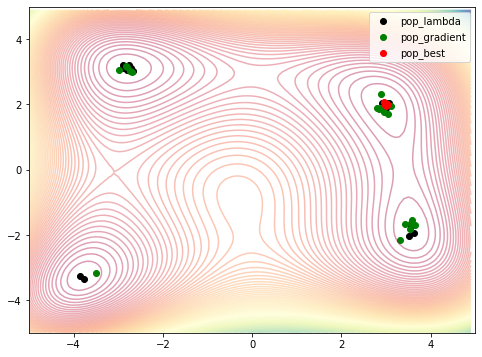

In [59]:
fig = plt.figure(figsize=(8,6))
ax = plt.subplot()
norm = colors.Normalize(vmin=Y.min(), vmax=Y.max())
its = 25

result_best = list(de_best(himmelblau, [(-5, 5)] * 2, its=its))
result_lambda = onepluslambda(himmelblau, its=its)
result_gradient = gradient(himmelblau, its=its)

def animate(i):
    ax.clear()
    ax.contour(X[0], X[1], Y, levels=100, cmap='Spectral', alpha=0.4, norm=norm)
    pop_lambda = result_lambda[i]
    ax.scatter(pop_lambda[:,0], pop_lambda[:,1], label="pop_lambda", c='k')
    pop_gradient = result_gradient[i]
    ax.scatter(pop_gradient[:,0], pop_gradient[:,1], label="pop_gradient", c='g')
    pop_best = result_best[i]
    ax.scatter(pop_best[:,0], pop_best[:,1], label="pop_best", c='r')
    ax.set_ylim(-5, 5)
    ax.set_xlim(-5, 5)
    ax.legend()
    ax.plot()

anim = animation.FuncAnimation(fig, animate, frames=its, interval=500)
HTML(anim.to_html5_video())